# Import functions for all processing
Put this notebook inside passive_interval_oddball_202412 project folder. The fllowing is the same as main.py at the beginning.

In [62]:
import sys
import warnings
warnings.filterwarnings('ignore')

import gc
import os
import argparse
from datetime import datetime

from modules import Trialization
from modules.ReadResults import read_ops

def combine_session_config_list(session_config_list):
    list_session_data_path = []
    for sc in session_config_list['list_config']:
        list_session_data_path += [
            os.path.join('results', sc['session_folder'], n)
            for n in sc['list_session_name'].keys()]
    list_session_name = [sc['list_session_name'] for sc in session_config_list['list_config']]
    list_session_name = {k: v for d in list_session_name for k, v in d.items()}
    session_config_list['list_session_name'] = list_session_name
    session_config_list['list_session_data_path'] = list_session_data_path
    return session_config_list

# Define the folder name to the sessions you want to process

## Folder structure

This notebook should be SomeWhere/passive_interval_oddball_202412/quick_start.ipynb.

The data should be SomeWhere/passive_interval_oddball_202412/SubjectName/SessionName.

In this example, we use 1 session from the random paradigm, and the session data is SomeWhere/passive_interval_oddball_202412/test/VTYH02_PPC_20250109_3331Random.

## How to set the sessions going into the analysis

Change list_session_name elements in session_config_test to add or exclude sessions. No need to change anything else at this time.

## It works for both single and cross subject analysis

Here, session_config_test is for cross subject analysis, while session_config_list_test specify the info for one subject. If you are running single subject analysis, list_config in session_config_list_test should have only 1 element for that subject.

## Using short long session as example below

In [148]:
session_config_test = {
        'list_session_name' : {
            #'VTYH02_PPC_20250127_4131FixJitterOdd' : 'fix_jitter_odd',
            'VTYH02_PPC_20250123_4131FixJitterOdd' : 'fix_jitter_odd',
            #'VTYH02_PPC_20250122_4131FixJitterOdd' : 'fix_jitter_odd',
            #'VTYH02_PPC_20250121_4131FixJitterOdd' : 'fix_jitter_odd',
            #'VTYH02_PPC_20250120_4131FixJitterOdd' : 'fix_jitter_odd',
            #'VTYH02_PPC_20250118_4131FixJitterOdd' : 'fix_jitter_odd',
            },
        'session_folder' : 'pupil',
        'sig_tag' : 'all',
        'force_label' : None,
        }
session_config_list_test = {
    'list_config': [
        session_config_test,
        ],
    'label_names' : {
        '-1':'Exc',
        '1':'Inh_VIP',
        '2':'Inh_SST',
        },
    'subject_name' : 'test',
    'output_filename' : 'test_passive.html'
    }

Read all saved processsed results.

Set other useful variables.

In [149]:
cate_list = [[-1,1,2]]

import matplotlib.pyplot as plt

label_names = {'-1':'Exc', '1':'Inh_VIP', '2':'Inh_SST'}
cate = [-1,1,2]
roi_id = None
norm_mode='none'
cluster_cmap = plt.cm.hsv
standard = 1
oddball = 1
block = 0
mode = 'post'
temp_folder = 'temp_'+session_config_list_test['subject_name']
if not os.path.exists(os.path.join('results', 'temp_'+session_config_list_test['subject_name'])):
    os.makedirs(os.path.join('results', 'temp_'+session_config_list_test['subject_name']))

Run this to get session configurations. There is only 1 session so the list will have only 1 element. The list structure is using for cross session or cross subject settings.

In [150]:
session_config_list = combine_session_config_list(session_config_list_test)
list_ops = read_ops(session_config_list['list_session_data_path'])
print(session_config_list)
print(f'number of sessions: {len(list_ops)}')

{'list_config': [{'list_session_name': {'VTYH02_PPC_20250123_4131FixJitterOdd': 'fix_jitter_odd'}, 'session_folder': 'pupil', 'sig_tag': 'all', 'force_label': None}], 'label_names': {'-1': 'Exc', '1': 'Inh_VIP', '2': 'Inh_SST'}, 'subject_name': 'test', 'output_filename': 'test_passive.html', 'list_session_name': {'VTYH02_PPC_20250123_4131FixJitterOdd': 'fix_jitter_odd'}, 'list_session_data_path': ['results\\pupil\\VTYH02_PPC_20250123_4131FixJitterOdd']}
number of sessions: 1


# Reading data results

Run the following to do trialization if it is not done yet. Otherwise, you can skip this.

In [151]:
#for i in range(len(list_ops)):
#    Trialization.run(list_ops[i])

Now you can read all results for analysis as follows. If you want to smooth the trace, set smooth=True instead.

In [152]:
from modules.ReadResults import read_all
[list_labels, list_masks,list_neural_trials, list_move_offset] = read_all(session_config_list, smooth=False)

Reading subject 1/1


100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  3.98it/s]


# Define utility functions

All the following codes are drawed from utils.py. No need to go through the details.



In [153]:
# rescale voltage recordings.
def rescale(data, upper, lower):
    data = data.copy()
    data = ( data - np.nanmin(data) ) / (np.nanmax(data) - np.nanmin(data))
    data = data * (upper - lower) + lower
    return data

# compute mean and sem for 3d array data.
def get_mean_sem(data, win_baseline=None):
    # compute mean.
    m = np.nanmean(data.reshape(-1, data.shape[-1]), axis=0)
    # compute sem.
    std = np.nanstd(data.reshape(-1, data.shape[-1]), axis=0)
    count = np.nansum(~np.isnan(data.reshape(-1, data.shape[-1])), axis=0)
    s = std / np.sqrt(count)
    return m, s

def plot_mean_sem(ax, t, m, s, c, l=None, a=1.0):
    ax.plot(t, m, color=c, label=l, alpha=a)
    ax.fill_between(t, m - s, m + s, color=c, alpha=0.25, edgecolor='none')
    ax.set_xlim([np.min(t), np.max(t)])

def plot_pupil(ax, nt, cp, c, u, l):
    cp = rescale(cp, u, l)
    ax.plot(nt, cp, color=c)

# Neural data alignment

We are using classes for modularizations. All the following codes are drawed from fig5_1451ShortLong.py.

## Import functions and run alignment

This is the same when initiating a plotter class.

In [154]:
import traceback
import numpy as np
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import savgol_filter

from modules.Alignment import run_get_stim_response
from modeling.clustering import get_mean_sem_cluster
from modeling.clustering import get_cluster_cate
from modeling.decoding import decoding_time_confusion
from modeling.decoding import decoding_time_single
from modeling.decoding import regression_time_frac
from modeling.generative import get_glm_cate
from modeling.quantifications import fit_trf_model

from utils import norm01
from utils import show_resource_usage
from utils import get_norm01_params
from utils import get_odd_stim_prepost_idx
from utils import get_mean_sem_win
from utils import get_mean_sem
from utils import get_neu_trial
from utils import get_frame_idx_from_time
from utils import get_split_idx
from utils import get_expect_interval
from utils import get_block_1st_idx
from utils import get_block_transition_idx
from utils import exclude_odd_stim
from utils import get_temporal_scaling_data
from utils import get_cmap_color
from utils import hide_all_axis
from utils import get_random_rotate_mat_3d
from utils import adjust_layout_isi_example_epoch
from utils import adjust_layout_neu
from utils import adjust_layout_3d_latent
from utils import add_legend
from utils import add_heatmap_colorbar
from utils import utils_basic

n_sess = len(list_neural_trials)
alignment = run_get_stim_response(temp_folder, list_neural_trials, expected='none')
list_stim_labels = alignment['list_stim_labels']
list_odd_idx = [
    get_odd_stim_prepost_idx(sl) for sl in list_stim_labels]
expect = np.nanmin(np.array([get_expect_interval(sl) for sl in list_stim_labels]),axis=0)
list_block_start = [get_block_1st_idx(sl, 3) for sl in list_stim_labels]
bin_win = [450,2550]
bin_num = 2
d_latent = 3

Aligning trials for session 1/1


trials: 100%|███████████████████████████| 1990/1990 [00:00<00:00, 22691.21it/s]


All the trialized neural data are in alignment. It has the following keys to access. Each element in alignment is a list. This list has the results for multiple sessions. 

Now show the trial for all neurons averaged during short and long oddball. Be advised, in this setting, the neural data has been averaged across trials and concatenate across sessions.

# Pupil alignment

In [155]:
color0 = 'dimgrey'
color1 = 'dodgerblue'
color2 = 'springgreen'

Now plot the pupil trace trial averaged on oddball interval during fix block.

shape of pupil data during short isi: (600,)
shape of pupil data during long isi: (600,)
shape of neural data within the window (short oddball): (122, 238)
shape of neural data within the window (long oddball): (122, 238)


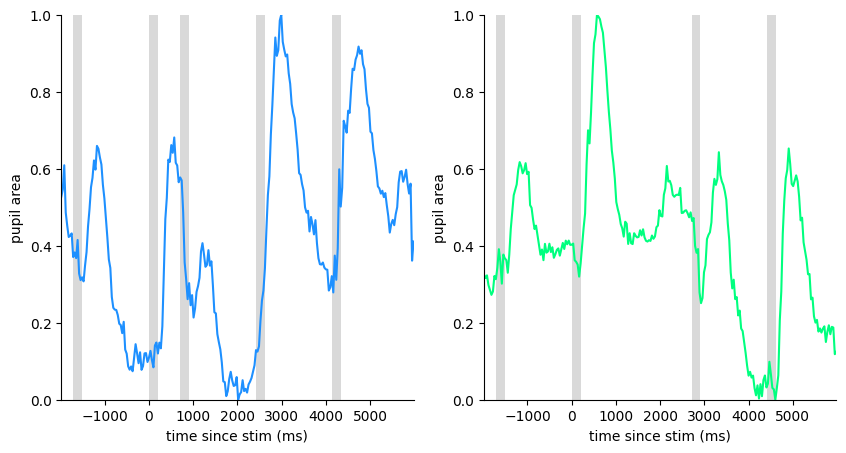

In [156]:
[_, [neu_seq_0, _, stim_seq_0, camera_pupil_0], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[0] for l in list_odd_idx],
    trial_param=[None, None, [0], None, [0], [0]],
    cate=cate, roi_id=None)
[_, [neu_seq_1, _, stim_seq_1, camera_pupil_1], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[1] for l in list_odd_idx],
    trial_param=[None, None, [0], None, [0], [0]],
    cate=cate, roi_id=None)
c_idx = stim_seq_0.shape[0]//2
print('shape of pupil data during short isi: {}'.format(camera_pupil_0.shape))
print('shape of pupil data during long isi: {}'.format(camera_pupil_1.shape))

win_eval = [-2000, 6000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, win_eval[0], win_eval[1])
neu_seq_win_0 = neu_seq_0[:,l_idx:r_idx]
neu_seq_win_1 = neu_seq_1[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]
print('shape of neural data within the window (short oddball): {}'.format(neu_seq_win_0.shape))
print('shape of neural data within the window (long oddball): {}'.format(neu_seq_win_1.shape))



cp_0 = camera_pupil_0[l_idx:r_idx]
cp_1 = camera_pupil_1[l_idx:r_idx]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for si in range(stim_seq_0.shape[0]):
    if stim_seq_0[si,0] >= win_eval[0] and stim_seq_0[si,1] <= win_eval[1]:
        axs[0].fill_between(
            stim_seq_0[si,:],
            0, 1,
            color=color0, edgecolor='none', alpha=0.25, step='mid')
for si in range(stim_seq_1.shape[0]):
    if stim_seq_1[si,0] >= win_eval[0] and stim_seq_1[si,1] <= win_eval[1]:
        axs[1].fill_between(
            stim_seq_1[si,:],
            0, 1,
            color=color0, edgecolor='none', alpha=0.25, step='mid')
plot_pupil(axs[0], neu_time_win, cp_0, color1, 0, 1)
plot_pupil(axs[1], neu_time_win, cp_1, color2, 0, 1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([neu_time_win[0], neu_time_win[-1]])
    ax.set_ylim([0, 1])
    ax.set_xlabel('time since stim (ms)')
    ax.set_ylabel('pupil area')


Now plot the pupil trace trial averaged on oddball interval during jitter block.

shape of pupil data during short isi: (600,)
shape of pupil data during long isi: (600,)
shape of neural data within the window (short oddball): (122, 238)
shape of neural data within the window (long oddball): (122, 238)


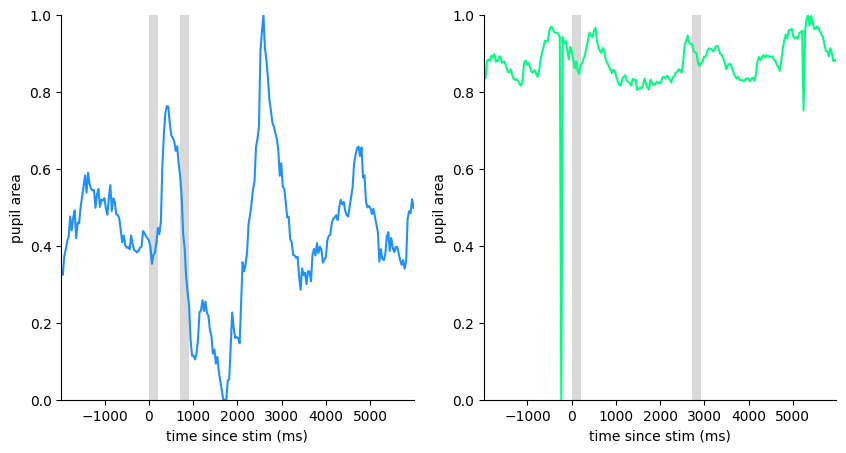

In [157]:
[_, [neu_seq_0, _, stim_seq_0, camera_pupil_0], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[0] for l in list_odd_idx],
    trial_param=[None, None, [1], None, [0], [0]],
    cate=cate, roi_id=None)
[_, [neu_seq_1, _, stim_seq_1, camera_pupil_1], _, _] = get_neu_trial(
    alignment, list_labels, list_stim_labels,
    trial_idx=[l[1] for l in list_odd_idx],
    trial_param=[None, None, [1], None, [0], [0]],
    cate=cate, roi_id=None)
c_idx = stim_seq_0.shape[0]//2
print('shape of pupil data during short isi: {}'.format(camera_pupil_0.shape))
print('shape of pupil data during long isi: {}'.format(camera_pupil_1.shape))

win_eval = [-2000, 6000]
l_idx, r_idx = get_frame_idx_from_time(alignment['neu_time'], 0, win_eval[0], win_eval[1])
neu_seq_win_0 = neu_seq_0[:,l_idx:r_idx]
neu_seq_win_1 = neu_seq_1[:,l_idx:r_idx]
neu_time_win = alignment['neu_time'][l_idx:r_idx]
print('shape of neural data within the window (short oddball): {}'.format(neu_seq_win_0.shape))
print('shape of neural data within the window (long oddball): {}'.format(neu_seq_win_1.shape))

cp_0 = camera_pupil_0[l_idx:r_idx]
cp_1 = camera_pupil_1[l_idx:r_idx]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

for si in [0,1]:
    if stim_seq_0[c_idx+si,0] >= win_eval[0] and stim_seq_0[c_idx+si,1] <= win_eval[1]:
        axs[0].fill_between(
            stim_seq_0[c_idx+si,:],
            0, 1,
            color=color0, edgecolor='none', alpha=0.25, step='mid')
for si in [0,1]:
    if stim_seq_1[c_idx+si,0] >= win_eval[0] and stim_seq_1[c_idx+si,1] <= win_eval[1]:
        axs[1].fill_between(
            stim_seq_1[c_idx+si,:],
            0, 1,
            color=color0, edgecolor='none', alpha=0.25, step='mid')
plot_pupil(axs[0], neu_time_win, cp_0, color1, 0, 1)
plot_pupil(axs[1], neu_time_win, cp_1, color2, 0, 1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlim([neu_time_win[0], neu_time_win[-1]])
    ax.set_ylim([0, 1])
    ax.set_xlabel('time since stim (ms)')
    ax.set_ylabel('pupil area')
